# Naive Bayes on  Amazon Finefood Reviews.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review


In [1]:
#Importing all the necessary packages.
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [2]:
# Now accesing the database where we have cleaned text. Cleaned Text means, the transformed text which has been Lemmatized, 
#Stemmed,etc. 
conn = sqlite3.connect('C:/Users/Swaroop/Desktop/Srikanth Reddy/final1.sqlite')
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", conn) 

In [3]:
#Converting the Unix time stamp to human readable form.
final['Time']=(pd.to_datetime(final['Time'],unit='ms')) 

In [4]:
#Here we can see that we have almost3.65lakh reviews.
final.shape

(364171, 12)

In [5]:
# Sorting the reviews accoring to Time stamp in ascending order so that old reviews remain in train and the latest reviews in test.
final2=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
(final2).shape #Taking alll the 3.4lakhs data

(364171, 12)

In [7]:
# Since KNN algorithm has memory problem(memory issue occurs if data is large), we will only take 1lakh points from the final2 datafram.
#final2=final2[0:200000]
#final2['Score'].value_counts()

In [8]:
#Importing all the necessary packages for performing Knn.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# Part I
# ============================== Data Preprocessing ===========================================
#Here we will be performing Naive Bayes on only reviews, thats why we take only CleanedText column in X.
#in variable 'y', we keep only Scores(positive,negative) for a the corresponding reviews. 
X = final2.CleanedText.values # end index is exclusive
y = final2.Score.values # showing you two ways of indexing a pandas df
X.shape # We can see that there are 3.6 lakh reviews(rows)


(364171,)

In [10]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB

def naiveB(X_in,y_in,X_tst,y_tst,VectorizationType):
    lb = LabelBinarizer()
    y_in = np.array([number[0] for number in lb.fit_transform(y_in)]) 
    y_tst= np.array([number[0] for number in lb.fit_transform(y_tst)])
    neighbors=[0.00001, 0.0001, 0.001, 0.01, 1, 10, 100] # this is the range of alphas
    cv_scores = []
    
    for n in neighbors:
        nb = MultinomialNB(alpha=n)
        scores = cross_val_score(nb, X_in, y_in, cv=10, scoring='f1')
        cv_scores.append(scores.mean())
    MSE = [1 - x for x in cv_scores]# Misclassification Error
    optimal_alpha = neighbors[MSE.index(min(MSE))] # The value with leasrt misclassifcation error.
    
    best_nb = MultinomialNB(alpha=optimal_alpha)

    best_nb.fit(X_in, y_in)

    pred = best_nb.predict(X_tst)
    
    #acc = accuracy_score(y_tst, pred) * 100
    
    score=best_nb.score(X_tst, y_tst)
    
    top_negatives = best_nb.feature_log_prob_[0, :].argsort() #Acquiring the negative word's probabilities
    top_positives = best_nb.feature_log_prob_[1, :].argsort() #Acquiring the positive word's probabilities
    
    print('Details for ',VectorizationType,'Vectorization:')
    print('*'*100)
    print('\n')
    print('The F1 scoring on Test data is:', score)
    print('\n')
    print('Accuracy for MultinomialNB algorithm with alpha value =',optimal_alpha,', calculated using F1 as scoring metric is ' ,np.round(accuracy_score(y_tst, pred)*100))
        
    #plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    plt.plot(neighbors,cv_scores,'k') 
    plt.xlabel('Alpha Value')
    plt.ylabel('CV-Scores')
    plt.title('Alpha Value vs CV-Scores')
    plt.show()
    print('*' * 100)
    print('\n')
    print("The misclassification error for each alpha value is : ", np.round(MSE,3))
    print('\n')
    print('F1 score for MultinomialNB algorithm with alpha =',optimal_alpha,' is ' , np.round((f1_score(y_tst, pred,average= 'macro')*100),decimals = 2))
    print('\n')
    print('Recall for MultinomialNB agorithm with alpha =',optimal_alpha,' is ' , np.round((recall_score(y_tst, pred,average= 'macro')*100),decimals = 2))
    print('\n')
    print('Precision for MultinomialNB algorithm with aplha =',optimal_alpha,' is ' , np.round((precision_score(y_tst, pred,average= 'macro')*100),decimals = 2))
    print('\n')
    print ('\n Classification report for MultinomialNB algorithm with alpha =',optimal_alpha,' is \n ' , classification_report(y_tst,pred))
    cm = confusion_matrix(y_tst, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    print('\n The top Negative words:')
    print(np.take(vect.get_feature_names(), top_negatives[:20]))
    print('\n')
    print('\n Top Positive Words:')
    print(np.take(vect.get_feature_names(), top_positives[:20]))
    
    return best_nb
    
    

Here the dataset is highly imbalanced. So while calculating the correct hyperparameter, we cannnot use sccuracy as scoring metric. We have can choose either Precision or Recall, because these work very well on imbalanced data sets. Before finding the Hyperparameter, we have to change the Score cloumn values(positive,negative) to (1,0) respectively.


### Naive Bayes on Bag of Words

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer() #in scikit-learn
bow_train = vect.fit_transform(X_train) # Here we fit transform to the data

bow_train.get_shape() # We can see that the data has 80k rows and 33491 columns(unique words).

(291336, 63748)

In [13]:
bow_test=vect.transform(X_test) # Transforming the test data.
bow_test.get_shape()

(72835, 63748)

Details for  Bow Vectorization:
****************************************************************************************************


The F1 scoring on Test data is: 0.9048808951740235


Accuracy for MultinomialNB algorithm with alpha value = 1 , calculated using F1 as scoring metric is  90.0


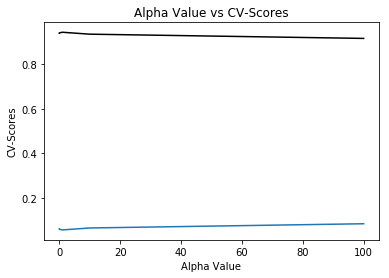

****************************************************************************************************


The misclassification error for each alpha value is :  [0.062 0.062 0.061 0.06  0.057 0.066 0.085]


F1 score for MultinomialNB algorithm with alpha = 1  is  81.95


Recall for MultinomialNB agorithm with alpha = 1  is  81.66


Precision for MultinomialNB algorithm with aplha = 1  is  82.24



 Classification report for MultinomialNB algorithm with alpha = 1  is 
               precision    recall  f1-score   support

          0       0.70      0.69      0.70     11496
          1       0.94      0.95      0.94     61339

avg / total       0.90      0.90      0.90     72835



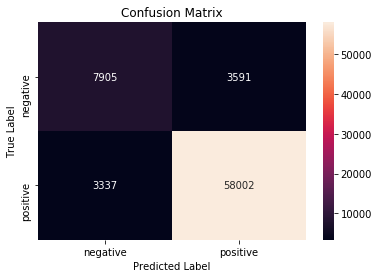


 The top Negative words:
['aa' 'muffuletta' 'mufin' 'mugg' 'muggi' 'muggin' 'muggl' 'mugi'
 'mugicha' 'muffl' 'mugo' 'mugwort' 'muh' 'muham' 'muhci' 'muito'
 'muixtur' 'mujadara' 'mujer' 'mugsi']



 Top Positive Words:
['possibili' 'brusher' 'embaress' 'brusel' 'sludgewat' 'sluge' 'litterali'
 'brus' 'embassas' 'litigi' 'lithgow' 'liteweight' 'litetron' 'smackaroo'
 'slse' 'smaeth' 'embolden' 'smake' 'embrass' 'smallth']
Wall time: 17.7 s


In [21]:
%%time
from sklearn.naive_bayes import MultinomialNB
nba=naiveB(bow_train,y_train,bow_test,y_test,'Bow')

### Naive Bayes on Tf-Idf  

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [23]:
vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = vect.fit_transform(X_train)
tfidf_train.shape

(291336, 2522924)

In [24]:
tfidf_test=vect.transform(X_test)

Details for  TFIDF Vectorization:
****************************************************************************************************


The F1 scoring on Test data is: 0.8938147868469829


Accuracy for MultinomialNB algorithm with alpha value = 0.001 , calculated using F1 as scoring metric is  89.0


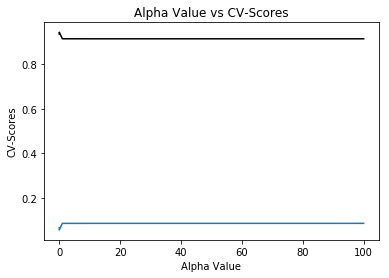

****************************************************************************************************


The misclassification error for each alpha value is :  [0.064 0.06  0.055 0.056 0.085 0.085 0.085]


F1 score for MultinomialNB algorithm with alpha = 0.001  is  73.6


Recall for MultinomialNB agorithm with alpha = 0.001  is  68.59


Precision for MultinomialNB algorithm with aplha = 0.001  is  88.48



 Classification report for MultinomialNB algorithm with alpha = 0.001  is 
               precision    recall  f1-score   support

          0       0.87      0.38      0.53     11496
          1       0.90      0.99      0.94     61339

avg / total       0.89      0.89      0.88     72835



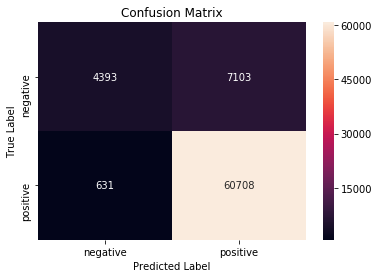


 The top Negative words:
['aa' 'one recogn' 'one recipi' 'one receptionist' 'one receipt'
 'one receipi' 'one recalcitr' 'one reasonabley' 'one realim' 'one reali'
 'one readili' 'one readi' 'one reader' 'one reach' 'one raynaud'
 'one raw' 'one raven' 'one rapunzel' 'one rang' 'one rancilio']



 Top Positive Words:
['pictur longtim' 'japans anim' 'unfortun greasi' 'cake crave'
 'cake crappi' 'japantown san' 'japantown starbuck' 'japantown tri'
 'deg usual' 'safer greeni' 'japans' 'safer got' 'japens' 'cake costco'
 'unfortun hate' 'japens sencha' 'unfortun hazelnut' 'unfortun head'
 'safer free' 'safer fda']


MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [25]:
naiveB(tfidf_train,y_train,tfidf_test,y_test,'TFIDF')

In [27]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "Hyper Parameter(alpha)", "Accuracy"]


In [28]:
x.add_row(["MultinomialNB on BoW",1,90.48])
x.add_row(["MultinomialNB on TfIdf",0.001,89.38])
print(x)

+------------------------+------------------------+----------+
|       Model Name       | Hyper Parameter(alpha) | Accuracy |
+------------------------+------------------------+----------+
|  MultinomialNB on BoW  |           1            |  90.48   |
| MultinomialNB on TfIdf |         0.001          |  89.38   |
+------------------------+------------------------+----------+


## Conclusion

1. After performing Bow and Tf-Idf on all the 3.6 lakhs reviews, it is clear that Multinomial Naive Bayes has given the almost same accuracy on both BOW and Tf-Idf, but Tf-Idf has performed better by a small margin. 